# Calculation of the TOV for the EOS: NSM changepoint kernel

## Alexandra Semposki

### Date: 29 January 2025

This notebook calculates the TOV equations for given data from the EOS from Bayesian model mixing. It then compares the 20n0 and 40n0 cutoff cases, and plots them in comparison to the NICER and LIGO data in the M-R posterior.

In [63]:
# import packages
%load_ext autoreload
%autoreload 2

import pickle
import sys
sys.path.append('../src/')
import scipy as sp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

from gp_utils import GaussianProcessRegressor2dNoise
from eos_utils import *
from tov_utils import *
from scripts import *

import sys
sys.path.append('../../../TOV_Solver')
from TOV_class import TOVsolver

# set params for plotting
setup_rc_params()

# define saturation up here
n0 = 0.164

# color plotting assistance
orders = [0, 1, 2, 3]
order_labels = [r'$\chi$EFT (N$^{3}$LO)', r'pQCD (N$^{2}$LO)', 'Mixed Model']
color_list = ['Reds', 'Blues','Purples', 'Oranges', 'Greens', 'Greys']
cmaps = [plt.get_cmap(name) for name in color_list[:len(orders)]]
colors = [cmap(0.7 - 0.1 * (i == 0)) for i, cmap in enumerate(cmaps)]
light_colors = [lighten_color(color, 0.5) for color in colors]
dark_colors = [lighten_color(color, 1.5) for color in colors]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
# load NICER data
miller = np.loadtxt('../data/NICER_data/NICER+XMM_J0740_RM.txt')
miller_0030_2 = np.loadtxt('../data/NICER_data/J0030_2spot_RM.txt')
miller_0030_3 = np.loadtxt('../data/NICER_data/J0030_3spot_RM.txt')

# load NICER J0437 data
j0437 = np.loadtxt('../data/NICER_data/J0437_data/samples/J0437_3C50_BKG_AGN_hiMN_lowXPSI_wmrsamples.dat')

In [65]:
# load in the LIGO data from the folder
df_insens = pd.read_csv('../data/LIGO_data/EoS-insensitive_posterior_samples.dat', sep='\s+')
display(df_insens)

df_maxmass = pd.read_csv('../data/LIGO_data/Parametrized-EoS_maxmass_posterior_samples.dat', sep='\s+')
display(df_maxmass)

# convert to a dict
LIGO_insens = df_insens.to_dict('list')
LIGO_maxmass = df_maxmass.to_dict('list')

,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.543236,1.205749,97.068200,248.541197,10.730811,9.358211
1,1.482590,1.253115,19.677667,280.480973,8.186003,9.833989
2,1.541613,1.206940,31.524739,235.511540,9.149591,9.373914
3,1.562878,1.191476,49.572338,409.681755,9.951128,10.102846
4,1.656298,1.128266,27.441288,246.930128,9.602853,9.395534
...,...,...,...,...,...,...
2916,1.508332,1.232504,91.421409,229.584025,10.730333,9.901073
2917,1.602577,1.163587,59.820623,266.473512,10.058355,9.314710
2918,1.561251,1.192543,12.951990,234.310549,8.475787,9.328835
2919,1.476021,1.258401,126.699863,346.595638,10.741590,10.844589


,m1_source_frame_Msun,m2_source_frame_Msun,Lambda1,Lambda2,Radius1_km,Radius2_km
0,1.637296,1.140765,66.373870,723.523060,10.887391,11.097352
1,1.612825,1.156845,191.207304,1335.339873,12.402063,12.349246
2,1.563015,1.191614,200.526550,1156.272842,12.285450,12.501216
3,1.625307,1.148567,134.833116,1439.597356,12.141489,12.627265
4,1.625909,1.148243,177.099466,1428.281697,12.399686,12.426146
...,...,...,...,...,...,...
2391,1.456157,1.275411,271.138172,593.167994,11.771023,11.732749
2392,1.363036,1.361102,275.144868,277.559025,11.146219,11.146212
2393,1.547311,1.202998,308.382837,1352.958123,12.800400,12.770993
2394,1.379074,1.345569,253.244553,293.279550,11.077769,11.070750


In [66]:
# LIGO data
x11 = np.asarray(LIGO_maxmass['Radius1_km'])
y11 = np.asarray(LIGO_maxmass['m1_source_frame_Msun'])
x22 = np.asarray(LIGO_maxmass['Radius2_km'])
y22 = np.asarray(LIGO_maxmass['m2_source_frame_Msun'])

In [84]:
# 20n0, no mean, no data, reduced
filename20 = 'NSM_changepoint_data_20n0_3_False_reduced' # zero mean without data
filename40 = 'NSM_changepoint_data_20n0_3_True_reduced'  # spline without data
with open('../data/pickled_data/'+filename20+'.pkl', 'rb') as fp:
    density20 = pickle.load(fp)
    edensdict20 = pickle.load(fp)
    pressuredict20 = pickle.load(fp)
    cs2dict20 = pickle.load(fp)

# 40n0, no mean, no data, reduced
with open('../data/pickled_data/'+filename40+'.pkl', 'rb') as fp:
    density40 = pickle.load(fp)
    edensdict40 = pickle.load(fp)
    pressuredict40 = pickle.load(fp)
    cs2dict40 = pickle.load(fp)
    
# look at the data types here and keys
print(edensdict20.shape) #.keys())
print(edensdict40.shape) #.keys())
print(pressuredict20.shape)
print(pressuredict40.shape)

(899, 961)
(899, 993)
(899, 961)
(899, 993)


In [85]:
# organize data for the TOV data helper
# pressuresamples20 = np.column_stack((pressuredict20['mean']-pressuredict20['std_dev'], \
#                                      pressuredict20['mean'], pressuredict20['mean']+pressuredict20['std_dev']))
# pressuresamples40 = np.column_stack((pressuredict40['mean']-pressuredict40['std_dev'], \
#                                      pressuredict40['mean'], pressuredict40['mean']+pressuredict40['std_dev']))
# edenssamples20 = np.column_stack((edensdict20['mean']-edensdict20['std'], \
#                                   edensdict20['mean'], edensdict20['mean']+edensdict20['std']))
# edenssamples40 = np.column_stack((edensdict40['mean']-edensdict40['std'], \
#                                   edensdict40['mean'], edensdict40['mean']+edensdict40['std']))

In [86]:
# create TOV data and feed envelopes
tovpressuredict20 = {
    'dens': density20,
    'samples': pressuredict20   #['samples']   #pressuresamples20
}

tovpressuredict40 = {
    'dens': density40,
    'samples': pressuredict40  #['samples']   #pressuresamples40
}

tovdict20 = tov_data(edensdict20, tovpressuredict20, save=True, \
                    filepath='../data/TOV_data/tov_{}.npz'.format(filename20))
tovdict40 = tov_data(edensdict40, tovpressuredict40, save=True, \
                    filepath='../data/TOV_data/tov_{}.npz'.format(filename40))

I'm done!
I'm done!


In [87]:
# call the solver once, send all data directly
tov20 = TOVsolver(eos_filepath='../data/TOV_data/tov_{}.npz'.format(filename20), tidal=False, moment=False)
#tov40 = TOVsolver(eos_filepath='../data/TOV_data/tov_{}.npz'.format(filename40), tidal=False, moment=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
rad20, prescent20, mass20 = tov20.tov_routine(verbose=False, write_to_file=False)
#rad40, prescent40, mass40 = tov40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  9.4027936088 Maximum mass:  1.3899151783781145 Central pressure:  399.5007639993038
Radius:  8.652312475999999 Maximum mass:  1.4972068493224258 Central pressure:  867.6756497154504
Radius:  10.2738877808 Maximum mass:  1.6402435345527226 Central pressure:  544.8206153354404
Radius:  8.625509578399999 Maximum mass:  1.4930603761119192 Central pressure:  867.6756497154504
Radius:  9.0007501448 Maximum mass:  1.4847494034408413 Central pressure:  636.240764772628
Radius:  9.9522530096 Maximum mass:  1.6726208165602516 Central pressure:  636.240764772628
Radius:  9.4429979552 Maximum mass:  1.612403235393687 Central pressure:  743.0010894672662
Radius:  9.6708225848 Maximum mass:  1.4772479985553457 Central pressure:  466.5364423805275
Radius:  9.201771876799999 Maximum mass:  1.4953653574822083 Central pressure:  636.240764772628
Radius:  9.1481660816 Maximum mass:  1.6038493067749924 Central pressure:  867.6756497154504
Radius:  9.5368080968 Maximum mass:  1.5939

Radius:  8.491495090399999 Maximum mass:  1.4362344659924717 Central pressure:  867.6756497154504
Radius:  9.2955820184 Maximum mass:  1.5520043535044221 Central pressure:  743.0010894672662
Radius:  8.933742900799999 Maximum mass:  1.5070525533762034 Central pressure:  743.0010894672662
Radius:  8.853334208 Maximum mass:  1.4867260648718088 Central pressure:  743.0010894672662
Radius:  8.893538554400001 Maximum mass:  1.4693455718287876 Central pressure:  743.0010894672662
Radius:  9.6440196872 Maximum mass:  1.6567217233706468 Central pressure:  743.0010894672662
Radius:  10.6089240008 Maximum mass:  1.5363435156459915 Central pressure:  292.9420362292324
Radius:  9.2955820184 Maximum mass:  1.5675841131730832 Central pressure:  743.0010894672662
Radius:  8.411086397599998 Maximum mass:  1.3837755159880585 Central pressure:  867.6756497154504
Radius:  8.786326963999999 Maximum mass:  1.4800687739067475 Central pressure:  743.0010894672662
Radius:  8.9471443496 Maximum mass:  1.442704

Radius:  9.9656544584 Maximum mass:  1.7247978208894095 Central pressure:  743.0010894672662
Radius:  9.4832023016 Maximum mass:  1.616757322097482 Central pressure:  743.0010894672662
Radius:  9.4966037504 Maximum mass:  1.5853742643702917 Central pressure:  636.240764772628
Radius:  9.0275530424 Maximum mass:  1.5611626556267417 Central pressure:  867.6756497154504
Radius:  7.9688385872000005 Maximum mass:  1.3371743281778472 Central pressure:  867.6756497154504
Radius:  9.429596506400001 Maximum mass:  1.5596624439788676 Central pressure:  636.240764772628
Radius:  9.8316399704 Maximum mass:  1.7084324189561921 Central pressure:  743.0010894672662
Radius:  8.6925168224 Maximum mass:  1.4529285961070573 Central pressure:  743.0010894672662
Radius:  9.3089834672 Maximum mass:  1.6184122089193933 Central pressure:  743.0010894672662
Radius:  8.6925168224 Maximum mass:  1.4568692240815615 Central pressure:  743.0010894672662
Radius:  10.5151138592 Maximum mass:  1.7691606216301135 Centr

Radius:  10.0728660488 Maximum mass:  1.547356228920786 Central pressure:  466.5364423805275
Radius:  9.791435623999998 Maximum mass:  1.771783152529209 Central pressure:  743.0010894672662
Radius:  9.8182385216 Maximum mass:  1.7291452886639151 Central pressure:  743.0010894672662
Radius:  9.8316399704 Maximum mass:  1.6681681156821375 Central pressure:  743.0010894672662
Radius:  8.0760501776 Maximum mass:  1.4007814872409716 Central pressure:  1013.2704295883759
Radius:  8.4378892952 Maximum mass:  1.3945758673929467 Central pressure:  867.6756497154504
Radius:  8.9069400032 Maximum mass:  1.5001274737595975 Central pressure:  743.0010894672662
Radius:  9.2687791208 Maximum mass:  1.5215308253110165 Central pressure:  743.0010894672662
Radius:  9.2419762232 Maximum mass:  1.446936432868155 Central pressure:  636.240764772628
Radius:  10.139873292799999 Maximum mass:  1.5872997674526603 Central pressure:  399.5007639993038
Radius:  8.8131298616 Maximum mass:  1.4886328520001229 Centr

Radius:  8.7997284128 Maximum mass:  1.4699385158850908 Central pressure:  867.6756497154504
Radius:  9.2419762232 Maximum mass:  1.6017693825977515 Central pressure:  743.0010894672662
Radius:  9.2419762232 Maximum mass:  1.5319613145990103 Central pressure:  636.240764772628
Radius:  7.9956414848 Maximum mass:  1.2997659315818517 Central pressure:  867.6756497154504
Radius:  9.1079617352 Maximum mass:  1.5625685745260167 Central pressure:  743.0010894672662
Radius:  10.260486332 Maximum mass:  1.8322743778947947 Central pressure:  636.240764772628
Radius:  9.2285747744 Maximum mass:  1.5685987003822155 Central pressure:  636.240764772628
Radius:  9.188370427999999 Maximum mass:  1.5879321589586806 Central pressure:  743.0010894672662
Radius:  8.5316994368 Maximum mass:  1.3539159269960799 Central pressure:  743.0010894672662
Radius:  8.9605457984 Maximum mass:  1.484092352221826 Central pressure:  743.0010894672662
Radius:  8.987348696 Maximum mass:  1.467072004710828 Central pressur

Radius:  9.1347646328 Maximum mass:  1.48536177897073 Central pressure:  636.240764772628
Radius:  9.322384916 Maximum mass:  1.627384333750994 Central pressure:  743.0010894672662
Radius:  9.9120486632 Maximum mass:  1.7151701532689951 Central pressure:  636.240764772628
Radius:  11.2387920944 Maximum mass:  1.6652023955836184 Central pressure:  250.84978717618554
Radius:  8.3708820512 Maximum mass:  1.2921543867019922 Central pressure:  743.0010894672662
Radius:  8.0760501776 Maximum mass:  1.329702437389781 Central pressure:  867.6756497154504
Radius:  9.4161950576 Maximum mass:  1.570975609904797 Central pressure:  743.0010894672662
Radius:  11.077974708800001 Maximum mass:  1.659521813880786 Central pressure:  342.0973067434033
Radius:  8.839932759199998 Maximum mass:  1.482054283132807 Central pressure:  867.6756497154504
Radius:  8.732721168800001 Maximum mass:  1.4514025220154205 Central pressure:  743.0010894672662
Radius:  10.7697413864 Maximum mass:  1.5118168992356087 Centr

Radius:  9.630618238399999 Maximum mass:  1.6181912481662053 Central pressure:  636.240764772628
Radius:  9.0811588376 Maximum mass:  1.5273272191016298 Central pressure:  743.0010894672662
Radius:  8.786326963999999 Maximum mass:  1.3775418371014343 Central pressure:  743.0010894672662
Radius:  11.171784850399998 Maximum mass:  1.722877582879551 Central pressure:  292.9420362292324
Radius:  9.6842240336 Maximum mass:  1.683998374652938 Central pressure:  636.240764772628
Radius:  9.4161950576 Maximum mass:  1.4830937347965483 Central pressure:  636.240764772628
Radius:  8.839932759199998 Maximum mass:  1.4872843919447167 Central pressure:  867.6756497154504
Radius:  9.4161950576 Maximum mass:  1.455301008352098 Central pressure:  544.8206153354404
Radius:  10.6491283472 Maximum mass:  1.5262864905193196 Central pressure:  250.84978717618554
Radius:  8.5316994368 Maximum mass:  1.4467794971443106 Central pressure:  867.6756497154504
Radius:  9.6708225848 Maximum mass:  1.68591785553856

Radius:  8.987348696 Maximum mass:  1.4442663576435841 Central pressure:  636.240764772628
Radius:  9.05435594 Maximum mass:  1.496400191553704 Central pressure:  636.240764772628
Radius:  8.8131298616 Maximum mass:  1.447276954927647 Central pressure:  743.0010894672662
Radius:  10.4079022688 Maximum mass:  1.6539531479621985 Central pressure:  466.5364423805275
Radius:  9.161567530400001 Maximum mass:  1.5415348625315233 Central pressure:  743.0010894672662
Radius:  8.504896539199999 Maximum mass:  1.4016993207376733 Central pressure:  636.240764772628
Radius:  8.5451008856 Maximum mass:  1.409966691146397 Central pressure:  743.0010894672662
Radius:  9.1347646328 Maximum mass:  1.5192822791367238 Central pressure:  743.0010894672662
Radius:  8.732721168800001 Maximum mass:  1.4836525930454894 Central pressure:  743.0010894672662
Radius:  9.3089834672 Maximum mass:  1.5701117457771057 Central pressure:  743.0010894672662
Radius:  8.5451008856 Maximum mass:  1.4163794651773711 Central

Radius:  9.0007501448 Maximum mass:  1.5698389229825243 Central pressure:  743.0010894672662
Radius:  10.7697413864 Maximum mass:  1.7372520206424973 Central pressure:  399.5007639993038
Radius:  8.9471443496 Maximum mass:  1.4162217916432371 Central pressure:  743.0010894672662
Radius:  8.625509578399999 Maximum mass:  1.4555754181204401 Central pressure:  867.6756497154504
Radius:  9.858442868000001 Maximum mass:  1.6486321828233417 Central pressure:  636.240764772628
Radius:  8.786326963999999 Maximum mass:  1.4982298784381707 Central pressure:  867.6756497154504
Radius:  8.250269012 Maximum mass:  1.375270593030464 Central pressure:  867.6756497154504
Radius:  8.4244878464 Maximum mass:  1.4140174866388224 Central pressure:  867.6756497154504
Radius:  9.657421136 Maximum mass:  1.4357814062875391 Central pressure:  466.5364423805275
Radius:  12.40471814 Maximum mass:  1.7049736690242026 Central pressure:  157.510626754264
Radius:  10.220281985599998 Maximum mass:  1.623559083340794

Radius:  9.0275530424 Maximum mass:  1.4827657659549216 Central pressure:  743.0010894672662
Radius:  10.7831428352 Maximum mass:  1.670471387696105 Central pressure:  399.5007639993038
Radius:  8.8131298616 Maximum mass:  1.544098645859503 Central pressure:  867.6756497154504
Radius:  10.5553182056 Maximum mass:  1.5905956493260756 Central pressure:  342.0973067434033
Radius:  9.040954491199999 Maximum mass:  1.588934092762694 Central pressure:  867.6756497154504
Radius:  9.3759907112 Maximum mass:  1.4626795955959941 Central pressure:  544.8206153354404
Radius:  9.523406647999998 Maximum mass:  1.532446044477093 Central pressure:  636.240764772628
Radius:  9.201771876799999 Maximum mass:  1.5524805968970259 Central pressure:  636.240764772628
Radius:  10.005858804799999 Maximum mass:  1.6697772346912623 Central pressure:  636.240764772628
Radius:  8.2770719096 Maximum mass:  1.422195441884349 Central pressure:  867.6756497154504
Radius:  9.871844316799999 Maximum mass:  1.64774781330

Radius:  8.987348696 Maximum mass:  1.4559711731253977 Central pressure:  636.240764772628
Radius:  9.2821805696 Maximum mass:  1.5702086749399242 Central pressure:  636.240764772628
Radius:  8.6121081296 Maximum mass:  1.4874888962856867 Central pressure:  743.0010894672662
Radius:  10.421303717599999 Maximum mass:  1.6355496742486209 Central pressure:  466.5364423805275
Radius:  7.928634240800001 Maximum mass:  1.3146722831837556 Central pressure:  867.6756497154504
Radius:  8.9069400032 Maximum mass:  1.4677147062217966 Central pressure:  743.0010894672662
Radius:  11.3192007872 Maximum mass:  1.6772437742427535 Central pressure:  342.0973067434033
Radius:  9.6440196872 Maximum mass:  1.535850810475292 Central pressure:  636.240764772628
Radius:  8.732721168800001 Maximum mass:  1.5004872448338917 Central pressure:  867.6756497154504
Radius:  8.397684948799998 Maximum mass:  1.4026214337747045 Central pressure:  867.6756497154504
Radius:  9.2955820184 Maximum mass:  1.60500625847053

---

In [88]:
# do the mean results now if possible
pressuremean20 = np.nanmean(pressuredict20, axis=1)
pressurestd20 = np.nanstd(pressuredict20, axis=1)
edensmean20 = np.nanmean(edensdict20, axis=1)
edensstd20 = np.nanstd(edensdict20, axis=1)

# pressuremean40 = np.nanmean(pressuredict40, axis=1)
# pressurestd40 = np.nanstd(pressuredict40, axis=1)
# edensmean40 = np.nanmean(edensdict40, axis=1)
# edensstd40 = np.nanstd(edensdict40, axis=1)

# put this together for the routine
pressureenv20 = np.column_stack((pressuremean20-1.65*pressurestd20, pressuremean20, pressuremean20+1.65*pressurestd20))
#pressureenv40 = np.column_stack((pressuremean40-1.65*pressurestd40, pressuremean40, pressuremean40+1.65*pressurestd40))
edensenv20 = np.column_stack((edensmean20-1.65*edensstd20, edensmean20, edensmean20+1.65*edensstd20))
#edensenv40 = np.column_stack((edensmean40-1.65*edensstd40, edensmean40, edensmean40+1.65*edensstd40))

# make dicts
tovpressureenvdict20 = {
    'dens': density20,
    'samples': pressureenv20
}

# tovpressureenvdict40 = {
#     'dens': density40,
#     'samples': pressureenv40
#}

In [89]:
# run the TOV for the 90% envelopes (1.65 z score)
tovdictenv20 = tov_data(edensenv20, tovpressureenvdict20, save=True, \
                    filepath='../data/TOV_data/tov_env_{}.npz'.format(filename20))
# tovdictenv40 = tov_data(edensenv40, tovpressureenvdict40, save=True, \
#                     filepath='../data/TOV_data/tov_env_{}.npz'.format(filename40))

I'm done!


In [90]:
# run routine
# call the solver once, send all data directly
tovenv20 = TOVsolver(eos_filepath='../data/TOV_data/tov_env_{}.npz'.format(filename20), tidal=False, moment=False)
#tovenv40 = TOVsolver(eos_filepath='../data/TOV_data/tov_env_{}.npz'.format(filename40), tidal=False, moment=False)

# call routine once (should do its thing...check why central pressures are the same for different ones)
radenv20, prescentenv20, massenv20 = tovenv20.tov_routine(verbose=False, write_to_file=False)
#radenv40, prescentenv40, massenv40 = tovenv40.tov_routine(verbose=False, write_to_file=False)

Woo it worked!
Radius:  9.0811588376 Maximum mass:  1.5114005864885431 Central pressure:  743.0010894672662
Radius:  9.1079617352 Maximum mass:  1.522230871639815 Central pressure:  743.0010894672662
Radius:  9.0677573888 Maximum mass:  1.5226584180527076 Central pressure:  743.0010894672662


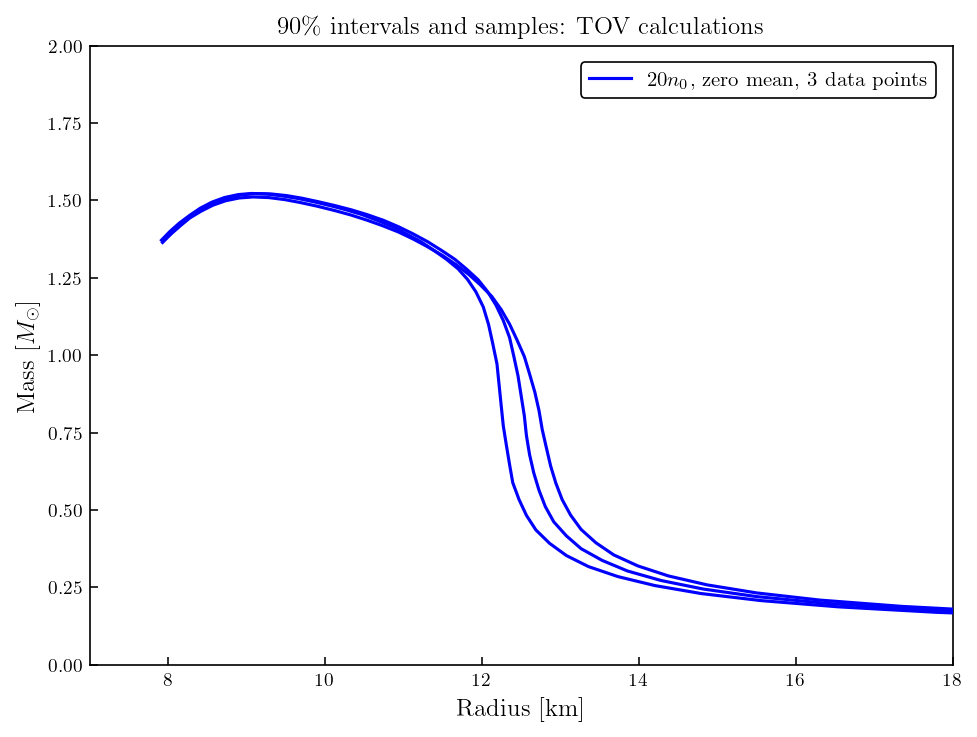

In [91]:
# 3 data point case to show
plt.axhline(y=4.0, color='blue', label=r'$20n_0$, zero mean, 3 data points')
#plt.axhline(y=4.0, color='darkorange', label=r'$20n_0$, spline mean, 2 data points')
plt.plot(radenv20, massenv20, color='blue', zorder=10)
#plt.plot(radenv40, massenv40, color='darkorange', zorder=10)
plt.title(r'90\% intervals and samples: TOV calculations',fontsize=12)
plt.xlabel(r'Radius [km]', fontsize=12)
plt.ylabel(r'Mass [$M_{\odot}$]', fontsize=12)
plt.xlim(7.0, 18.0)
plt.ylim(0.0, 2.0)
plt.legend(fontsize=10)
plt.show()

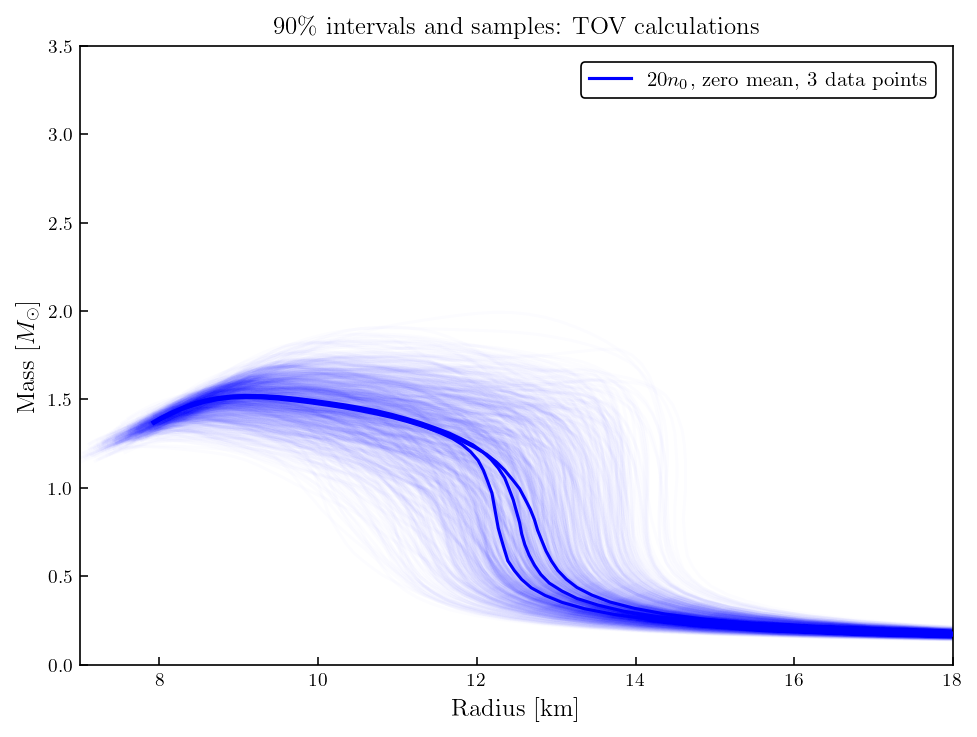

In [93]:
# plot these envelopes for each case (they will overlap, it's fine for now...)
plt.plot(rad20, mass20, color='blue', alpha=0.01)
plt.axhline(y=4.0, color='blue', label=r'$20n_0$, zero mean, 3 data points')
#plt.axhline(y=4.0, color='darkorange', label=r'$20n_0$, spline mean, 0 data points')
#plt.plot(rad40, mass40, color='darkorange', alpha=0.05)
plt.plot(radenv20, massenv20, color='blue', zorder=10)
#plt.plot(radenv40, massenv40, color='darkorange', zorder=10)
plt.title(r'90\% intervals and samples: TOV calculations',fontsize=12)
plt.xlabel(r'Radius [km]', fontsize=12)
plt.ylabel(r'Mass [$M_{\odot}$]', fontsize=12)
plt.xlim(7.0, 18.0)
plt.ylim(0.0, 3.5)
plt.legend(fontsize=10)
plt.show()

(961, 944)
(944, 961)


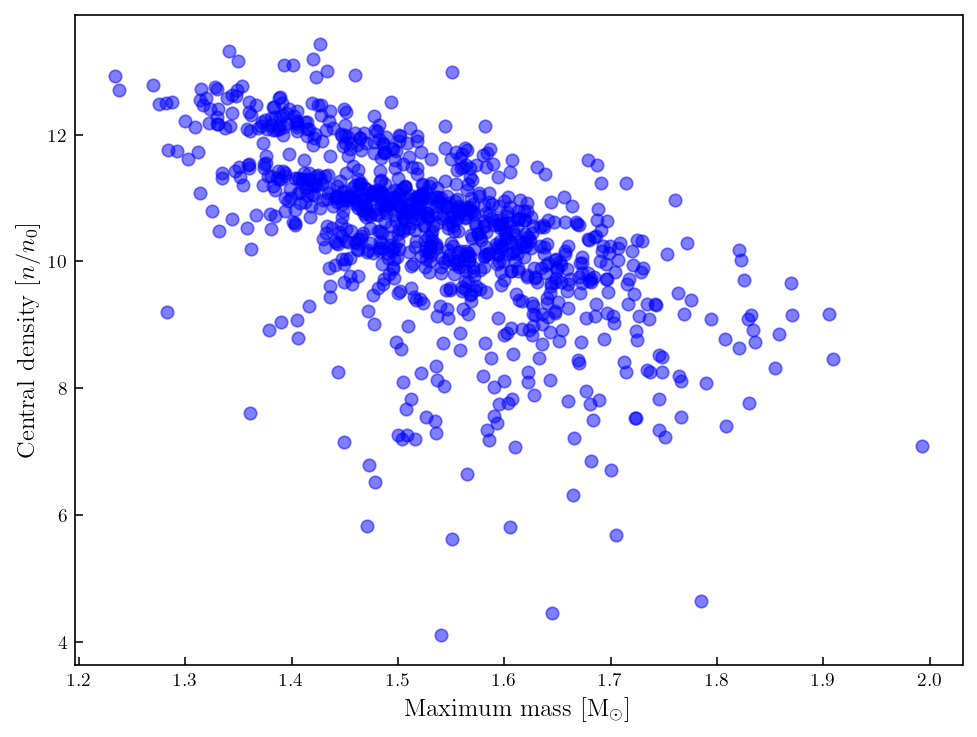

In [94]:
# central densities
cdens_20n0 = tov20.central_dens()
max_mass_20n0 = tov20.max_mass_arr
# cdens_40n0 = tov40.central_dens()
# max_mass_40n0 = tov40.max_mass_arr

# plot the maximum mass vs. central density
plt.scatter(max_mass_20n0, cdens_20n0/n0, marker='o', color='blue', alpha=0.5)
#plt.scatter(max_mass_40n0, cdens_40n0/n0, marker='o', color='darkorange', alpha=0.5)
plt.ylabel(r'Central density [$n/n_{0}]$', fontsize=12)
plt.xlabel(r'Maximum mass [M$_\odot$]', fontsize=12)
plt.show()

In [38]:
# pickle these
with open('../data/pickled_data/TOV_results_{}.pkl'.format(filename20), 'wb') as fp:
    pickle.dump(rad20, fp)
    pickle.dump(prescent20, fp)
    pickle.dump(mass20, fp)
    pickle.dump(cdens_20n0, fp)
    pickle.dump(max_mass_20n0, fp)
    print('TOV data saved successfully to file')
    
with open('../data/pickled_data/TOV_results_{}.pkl'.format(filename40), 'wb') as fp:
    pickle.dump(rad40, fp)
    pickle.dump(prescent40, fp)
    pickle.dump(mass40, fp)
    pickle.dump(cdens_40n0, fp)
    pickle.dump(max_mass_40n0, fp)
    print('TOV data saved successfully to file')

TOV data saved successfully to file
TOV data saved successfully to file


In [95]:
# exclude the points with less than 2.0 maximum mass and compare in histogram below
ind_20 = []
#ind_40 = []
for i in range(len(max_mass_20n0)):
    if max_mass_20n0[i] < 2.0:
        ind_20.append(i)
# for j in range(len(max_mass_40n0)):
#     if max_mass_40n0[j] < 2.0:
#         ind_40.append(j)

In [96]:
# delete the central densities that we don't want to keep
cdens_20_reduced = np.delete(cdens_20n0, ind_20)
#cdens_40_reduced = np.delete(cdens_40n0, ind_40)

## Histogram (all stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_72167/163007.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


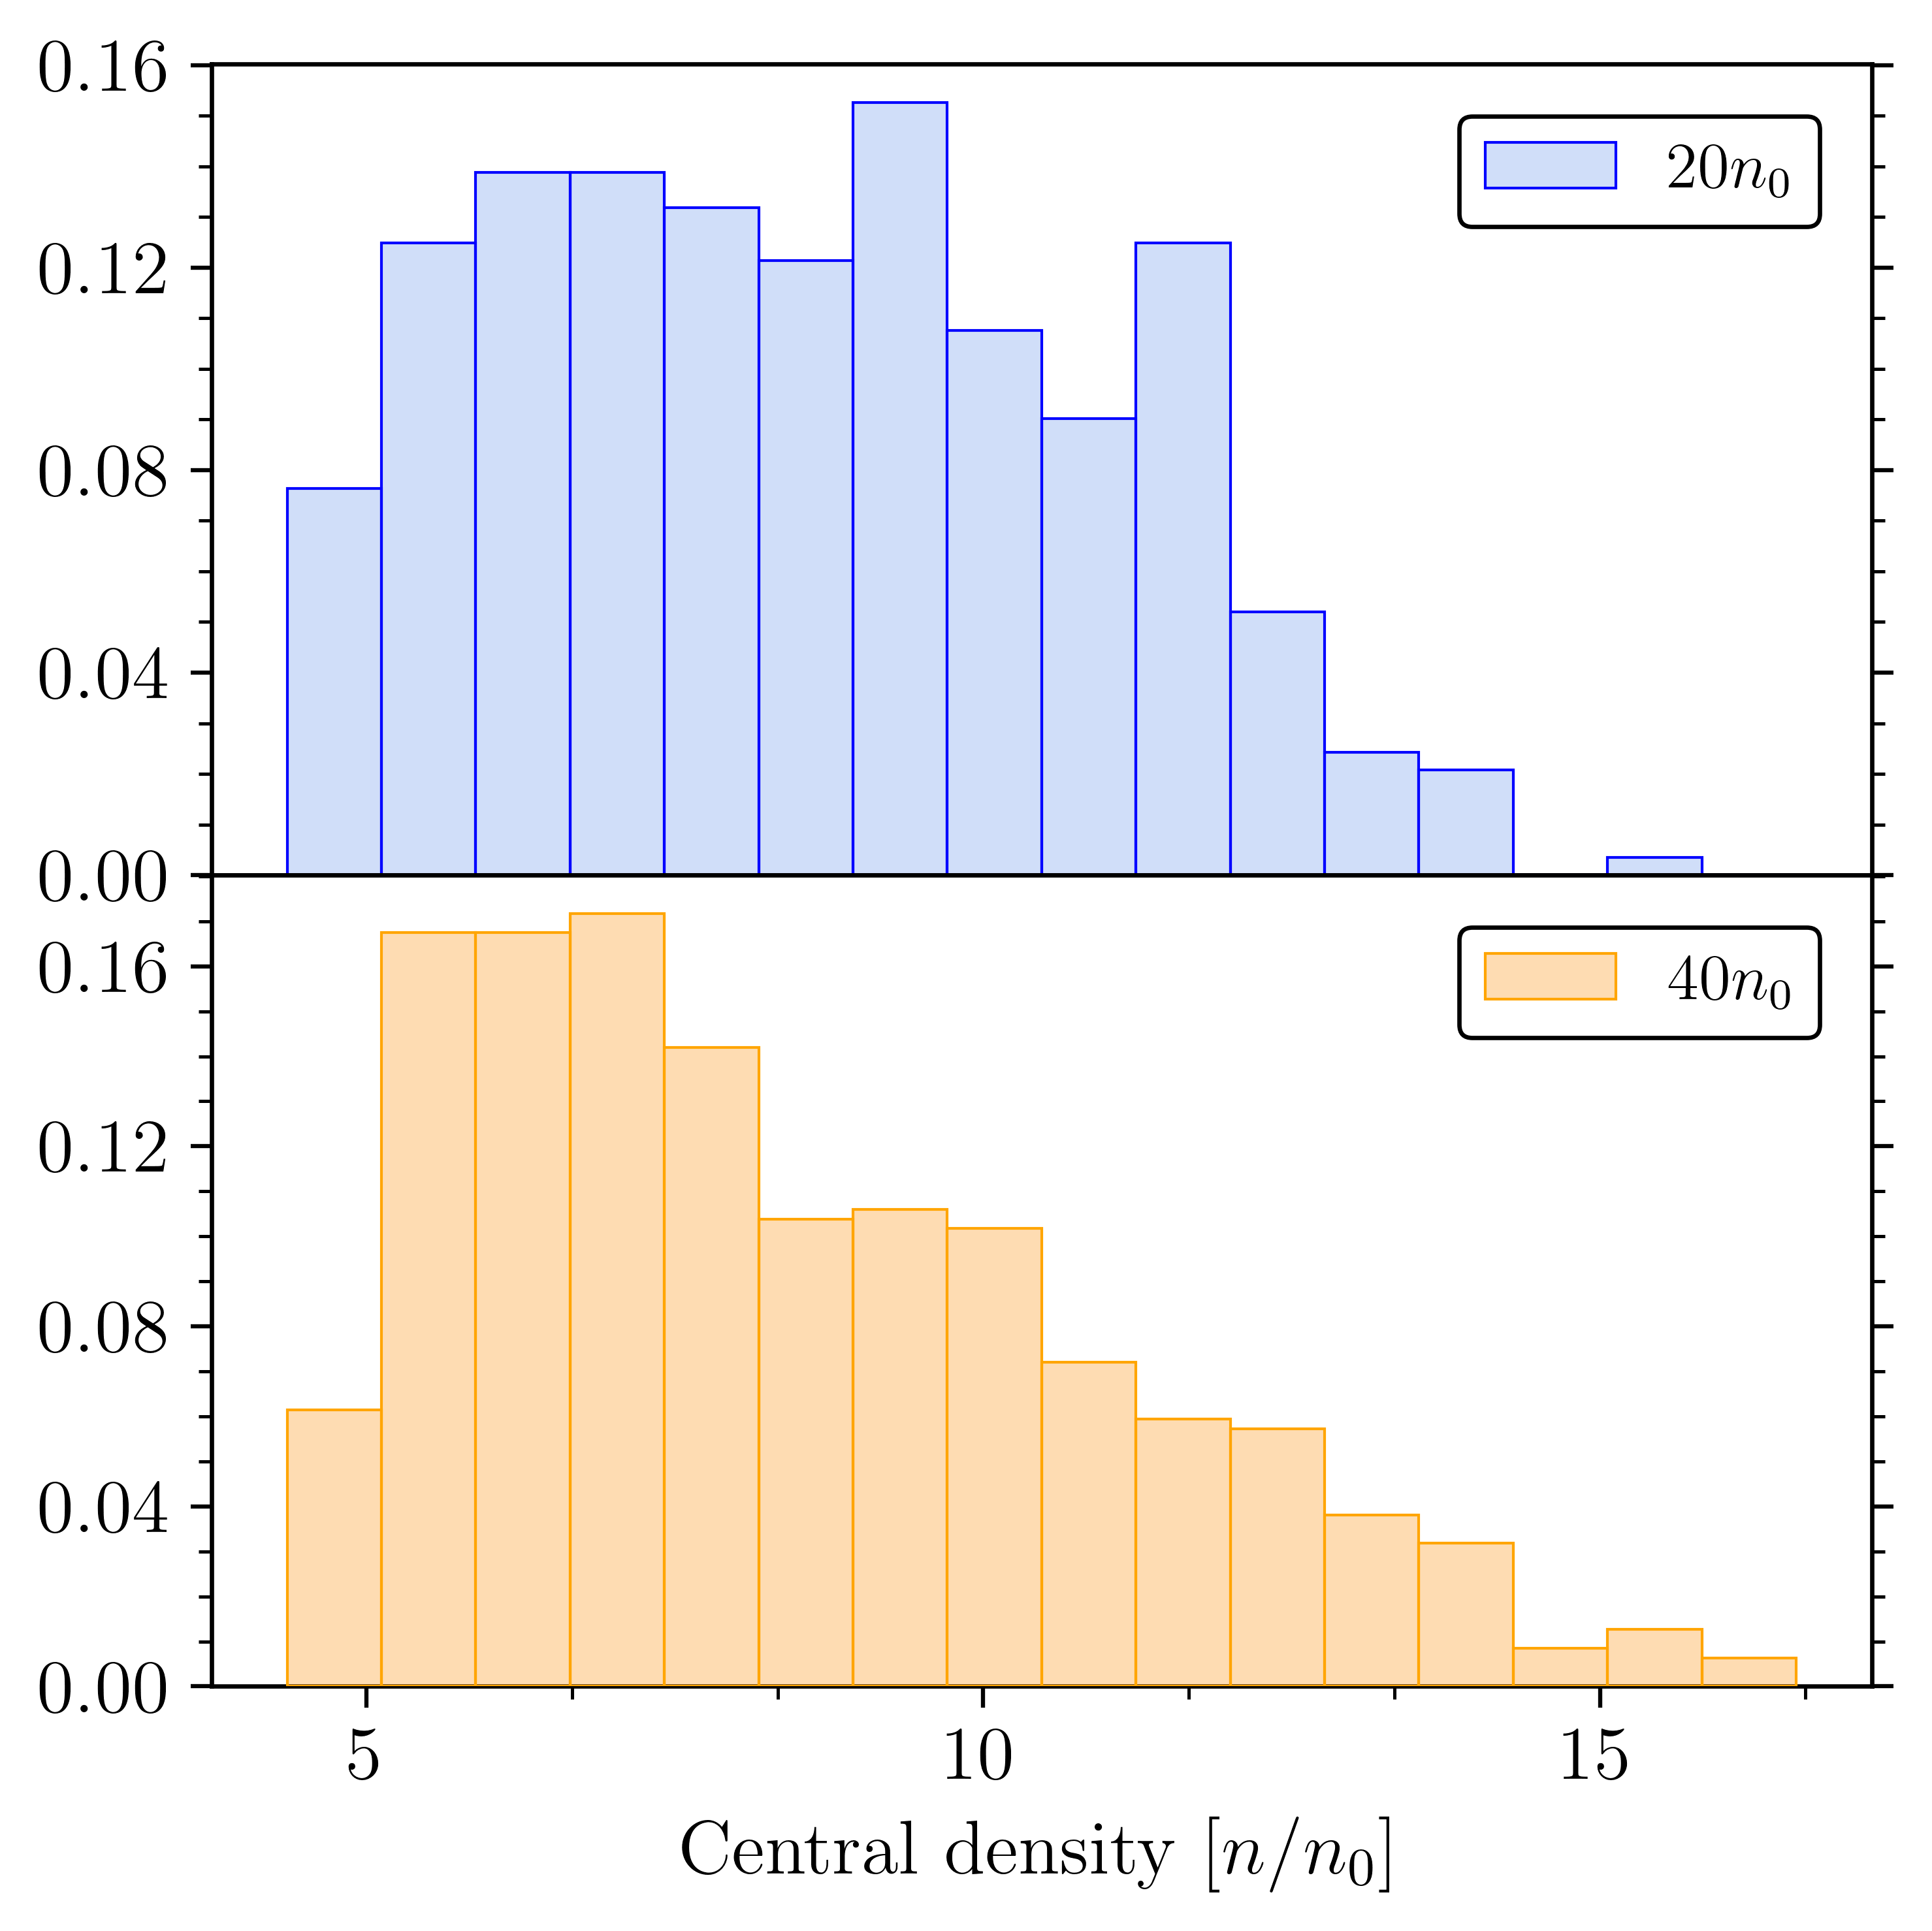

In [31]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True)
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.04))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[0].xaxis.set_major_locator(MultipleLocator(5))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.04))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].xaxis.set_major_locator(MultipleLocator(5))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(3))

cdens_scaled = cdens_20n0/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_72167/3998182965.py:50: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


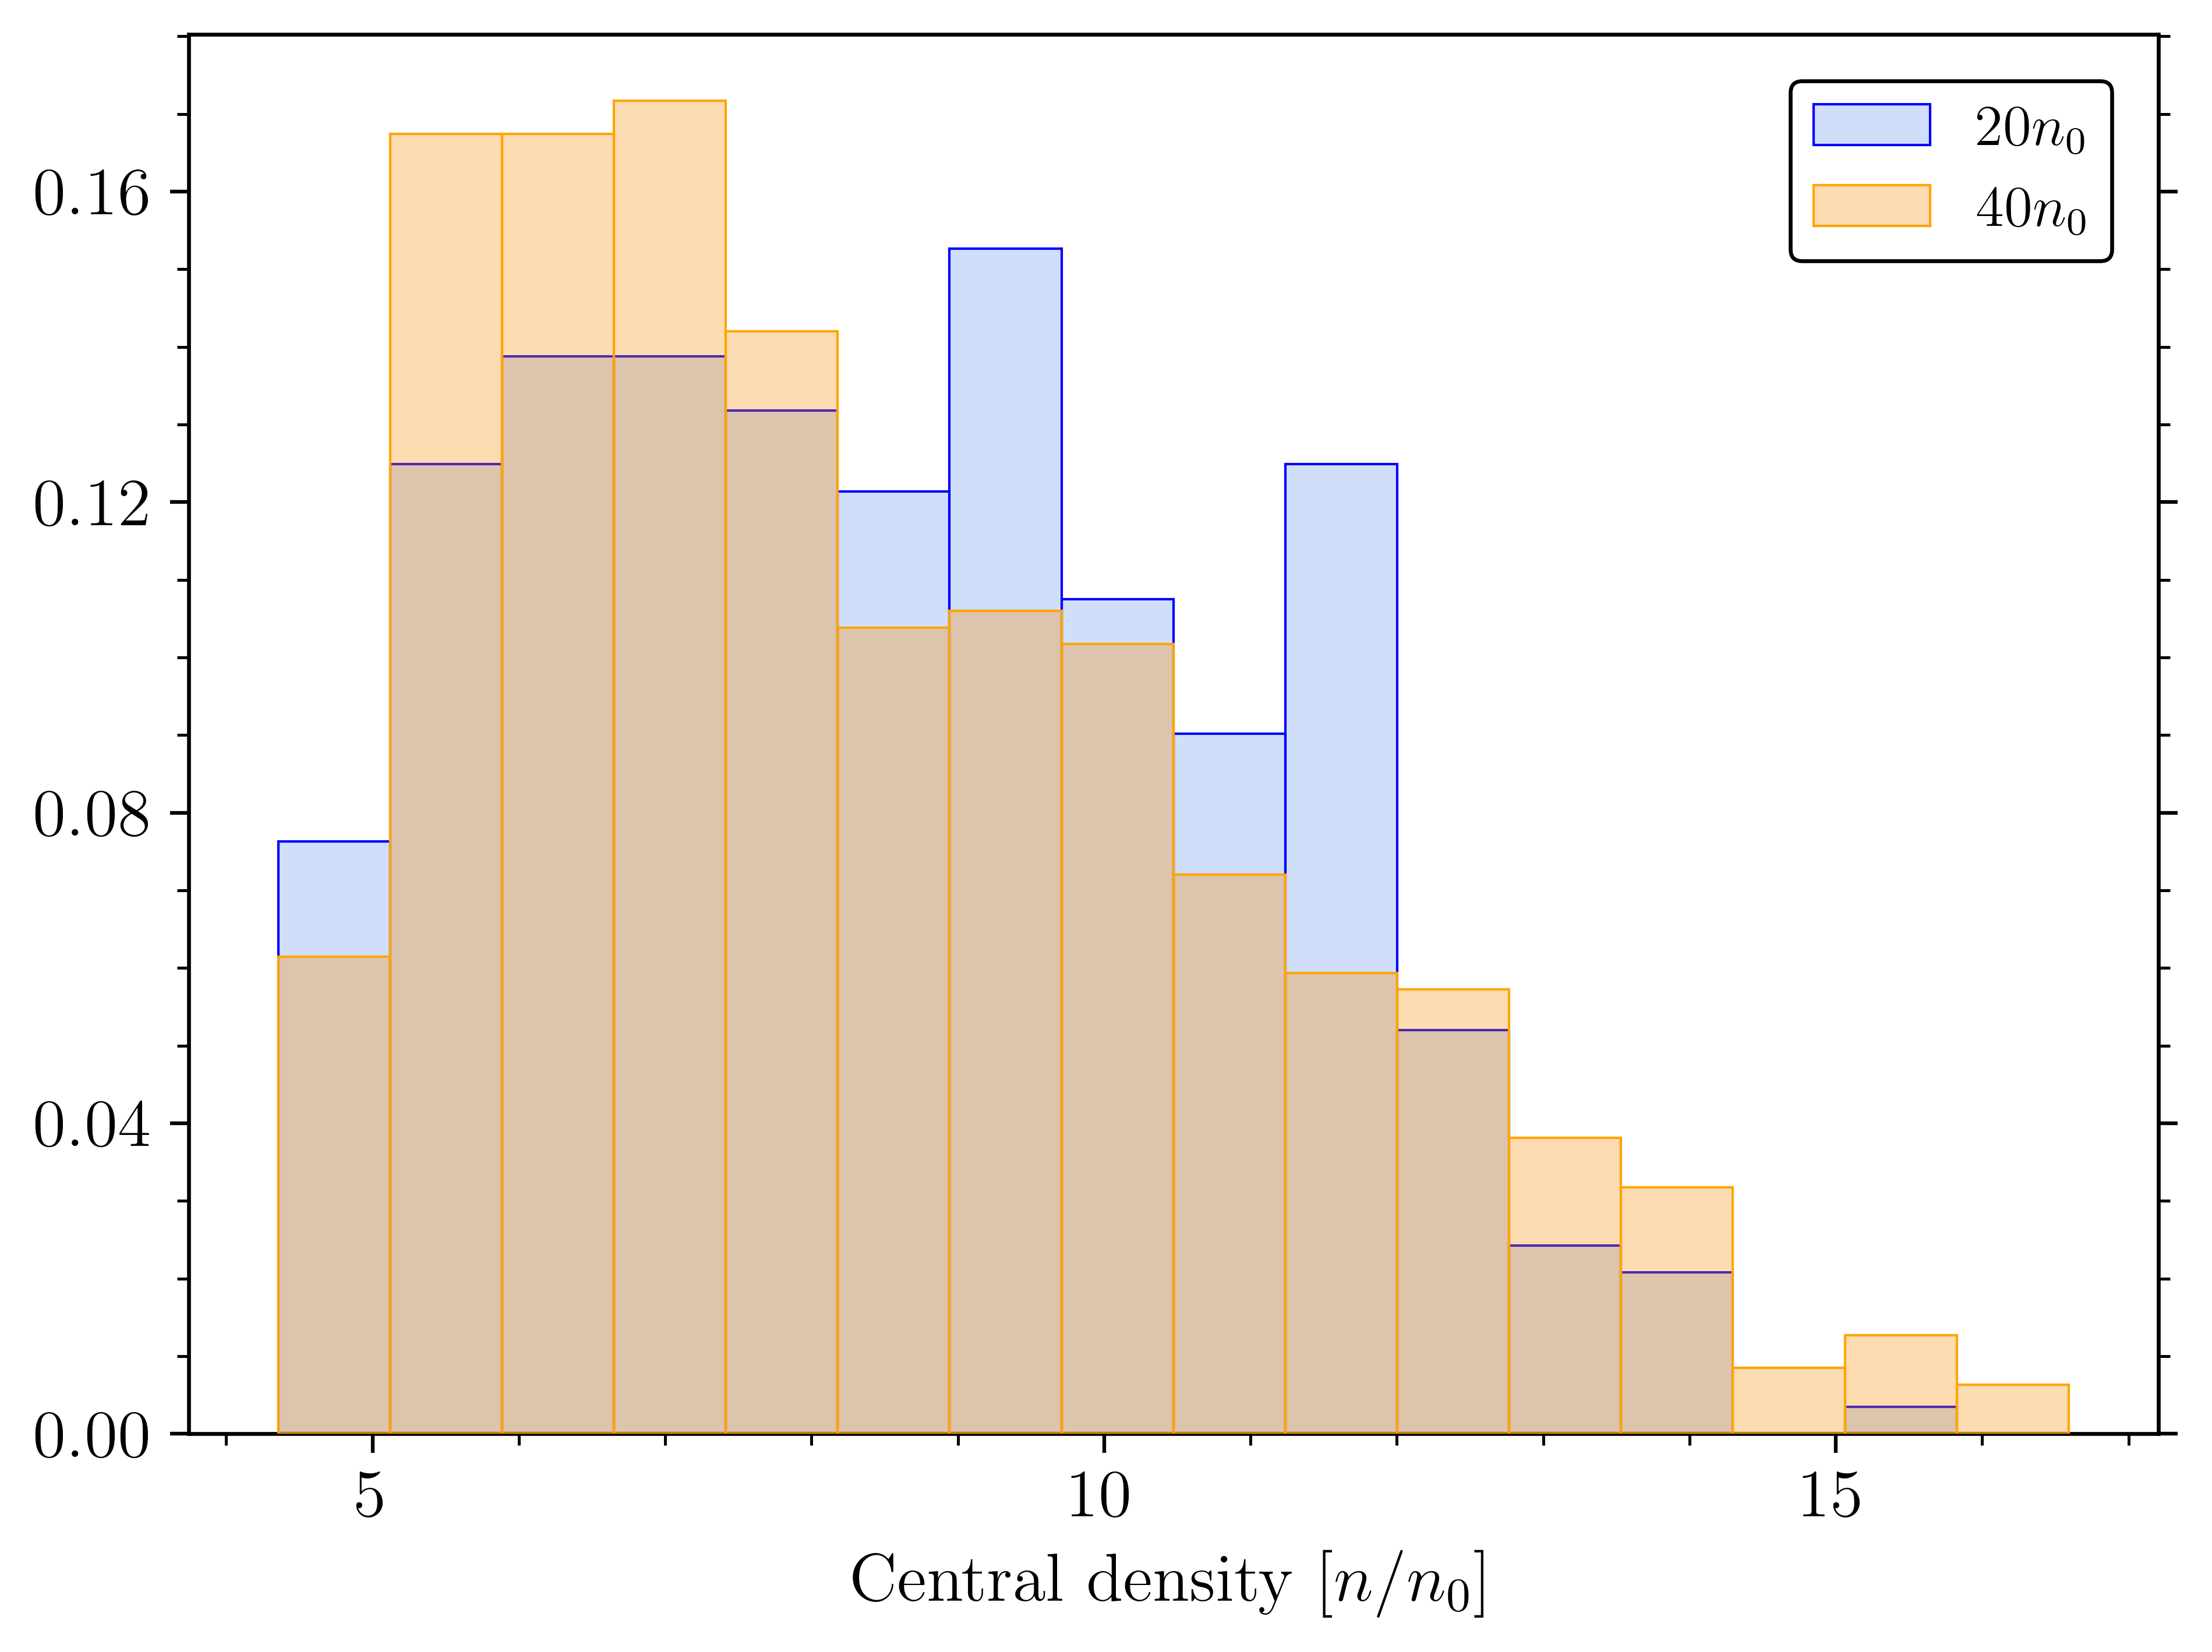

In [32]:
# histogram all on one plot from above
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.04))
ax.yaxis.set_minor_locator(AutoMinorLocator(4))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

cdens_scaled = cdens_20n0/n0
cdens_scaled_40 = cdens_40n0/n0

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_one_plot.png')
plt.show()

In [33]:
max_rad20, max_cpres20, max_mass20 = tov20.max_arrays()
max_rad40, max_cpres40, max_mass40 = tov40.max_arrays()

In [176]:
# save these central densities before you lose your mind
np.savez('cdens_20n0.npz', max_rad=max_rad20, max_cpres=max_cpres20, \
         max_mass=max_mass20, cdens=cdens_20n0_real)

np.savez('rpm_20n0.npz', rad=radius_data_20, cpres=pressure_data_20, mass=mass_data_20)

# save now the 40n0 stuff just in case
np.savez('cdens_40n0.npz', max_rad=max_rad40, max_cpres=max_cpres40, \
         max_mass=max_mass40, cdens=cdens_40n0)

np.savez('rpm_40n0.npz', rad=radius_data_40, cpres=pressure_data_40, mass=mass_data_40)

## Histogram (reduced stars)

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_72167/1360433307.py:61: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


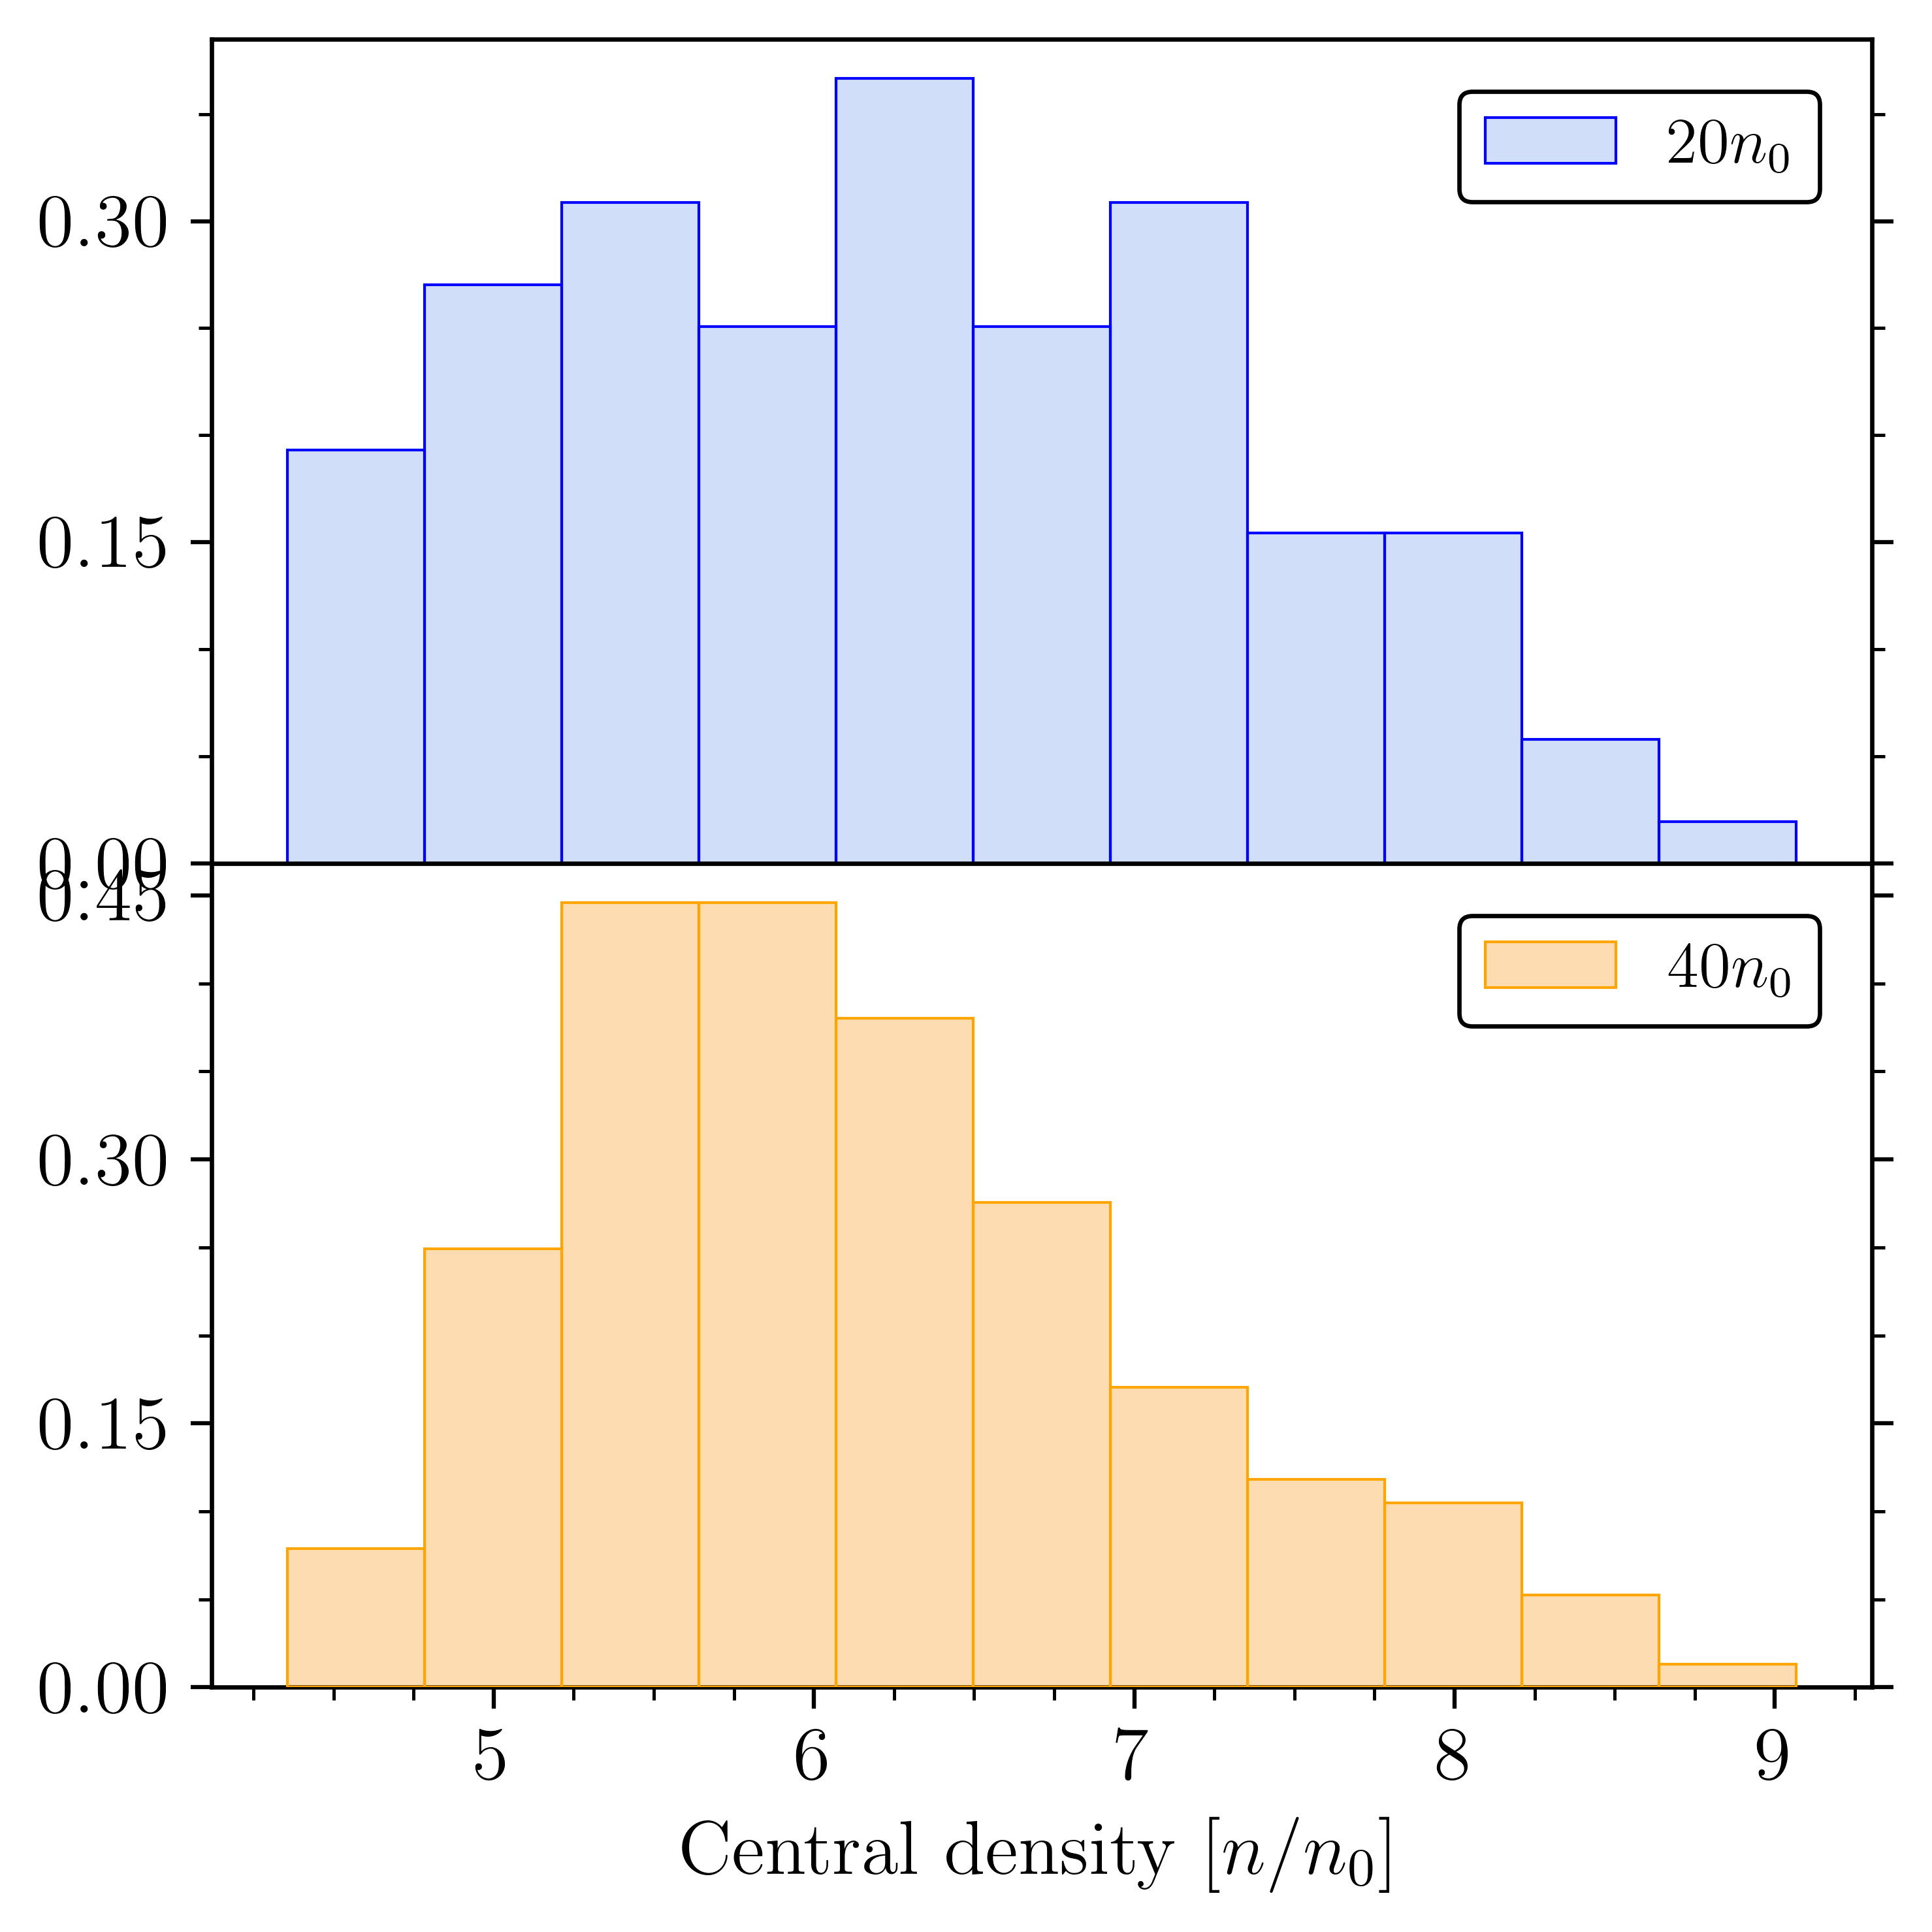

In [34]:
# bin the central densities and see what happens
fig, ax = plt.subplots(2, 1, figsize=(5,5), dpi=600, sharex=True, )
ax[0].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[0].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[0].yaxis.set_major_locator(MultipleLocator(0.15))
ax[0].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[0].xaxis.set_major_locator(MultipleLocator(1))
ax[0].xaxis.set_minor_locator(AutoMinorLocator(4))
ax[1].tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax[1].tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax[1].yaxis.set_major_locator(MultipleLocator(0.15))
ax[1].yaxis.set_minor_locator(AutoMinorLocator(3))
ax[1].xaxis.set_major_locator(MultipleLocator(1))
ax[1].xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# consistent binning
def freedman_diaconis_bin_width(data):
    q75, q25 = np.percentile(data, [75, 25])
    iqr = q75 - q25
    return 2 * iqr / np.cbrt(len(data))

# global dudes
maximum_cdens = max(max(cdens_scaled), max(cdens_scaled_40))
minimum_cdens = min(min(cdens_scaled), min(cdens_scaled_40))

bin_width = freedman_diaconis_bin_width(np.concatenate([cdens_scaled, cdens_scaled_40]))
bins = np.arange(minimum_cdens, maximum_cdens + bin_width, bin_width)

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax[0].hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax[1].hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax[1].set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax[0].legend(fontsize=12)
ax[1].legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced.png')
plt.show()

/var/folders/q4/wyq6nf1d29n2gxrsbvs1m01r0000gn/T/ipykernel_72167/4064960880.py:43: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


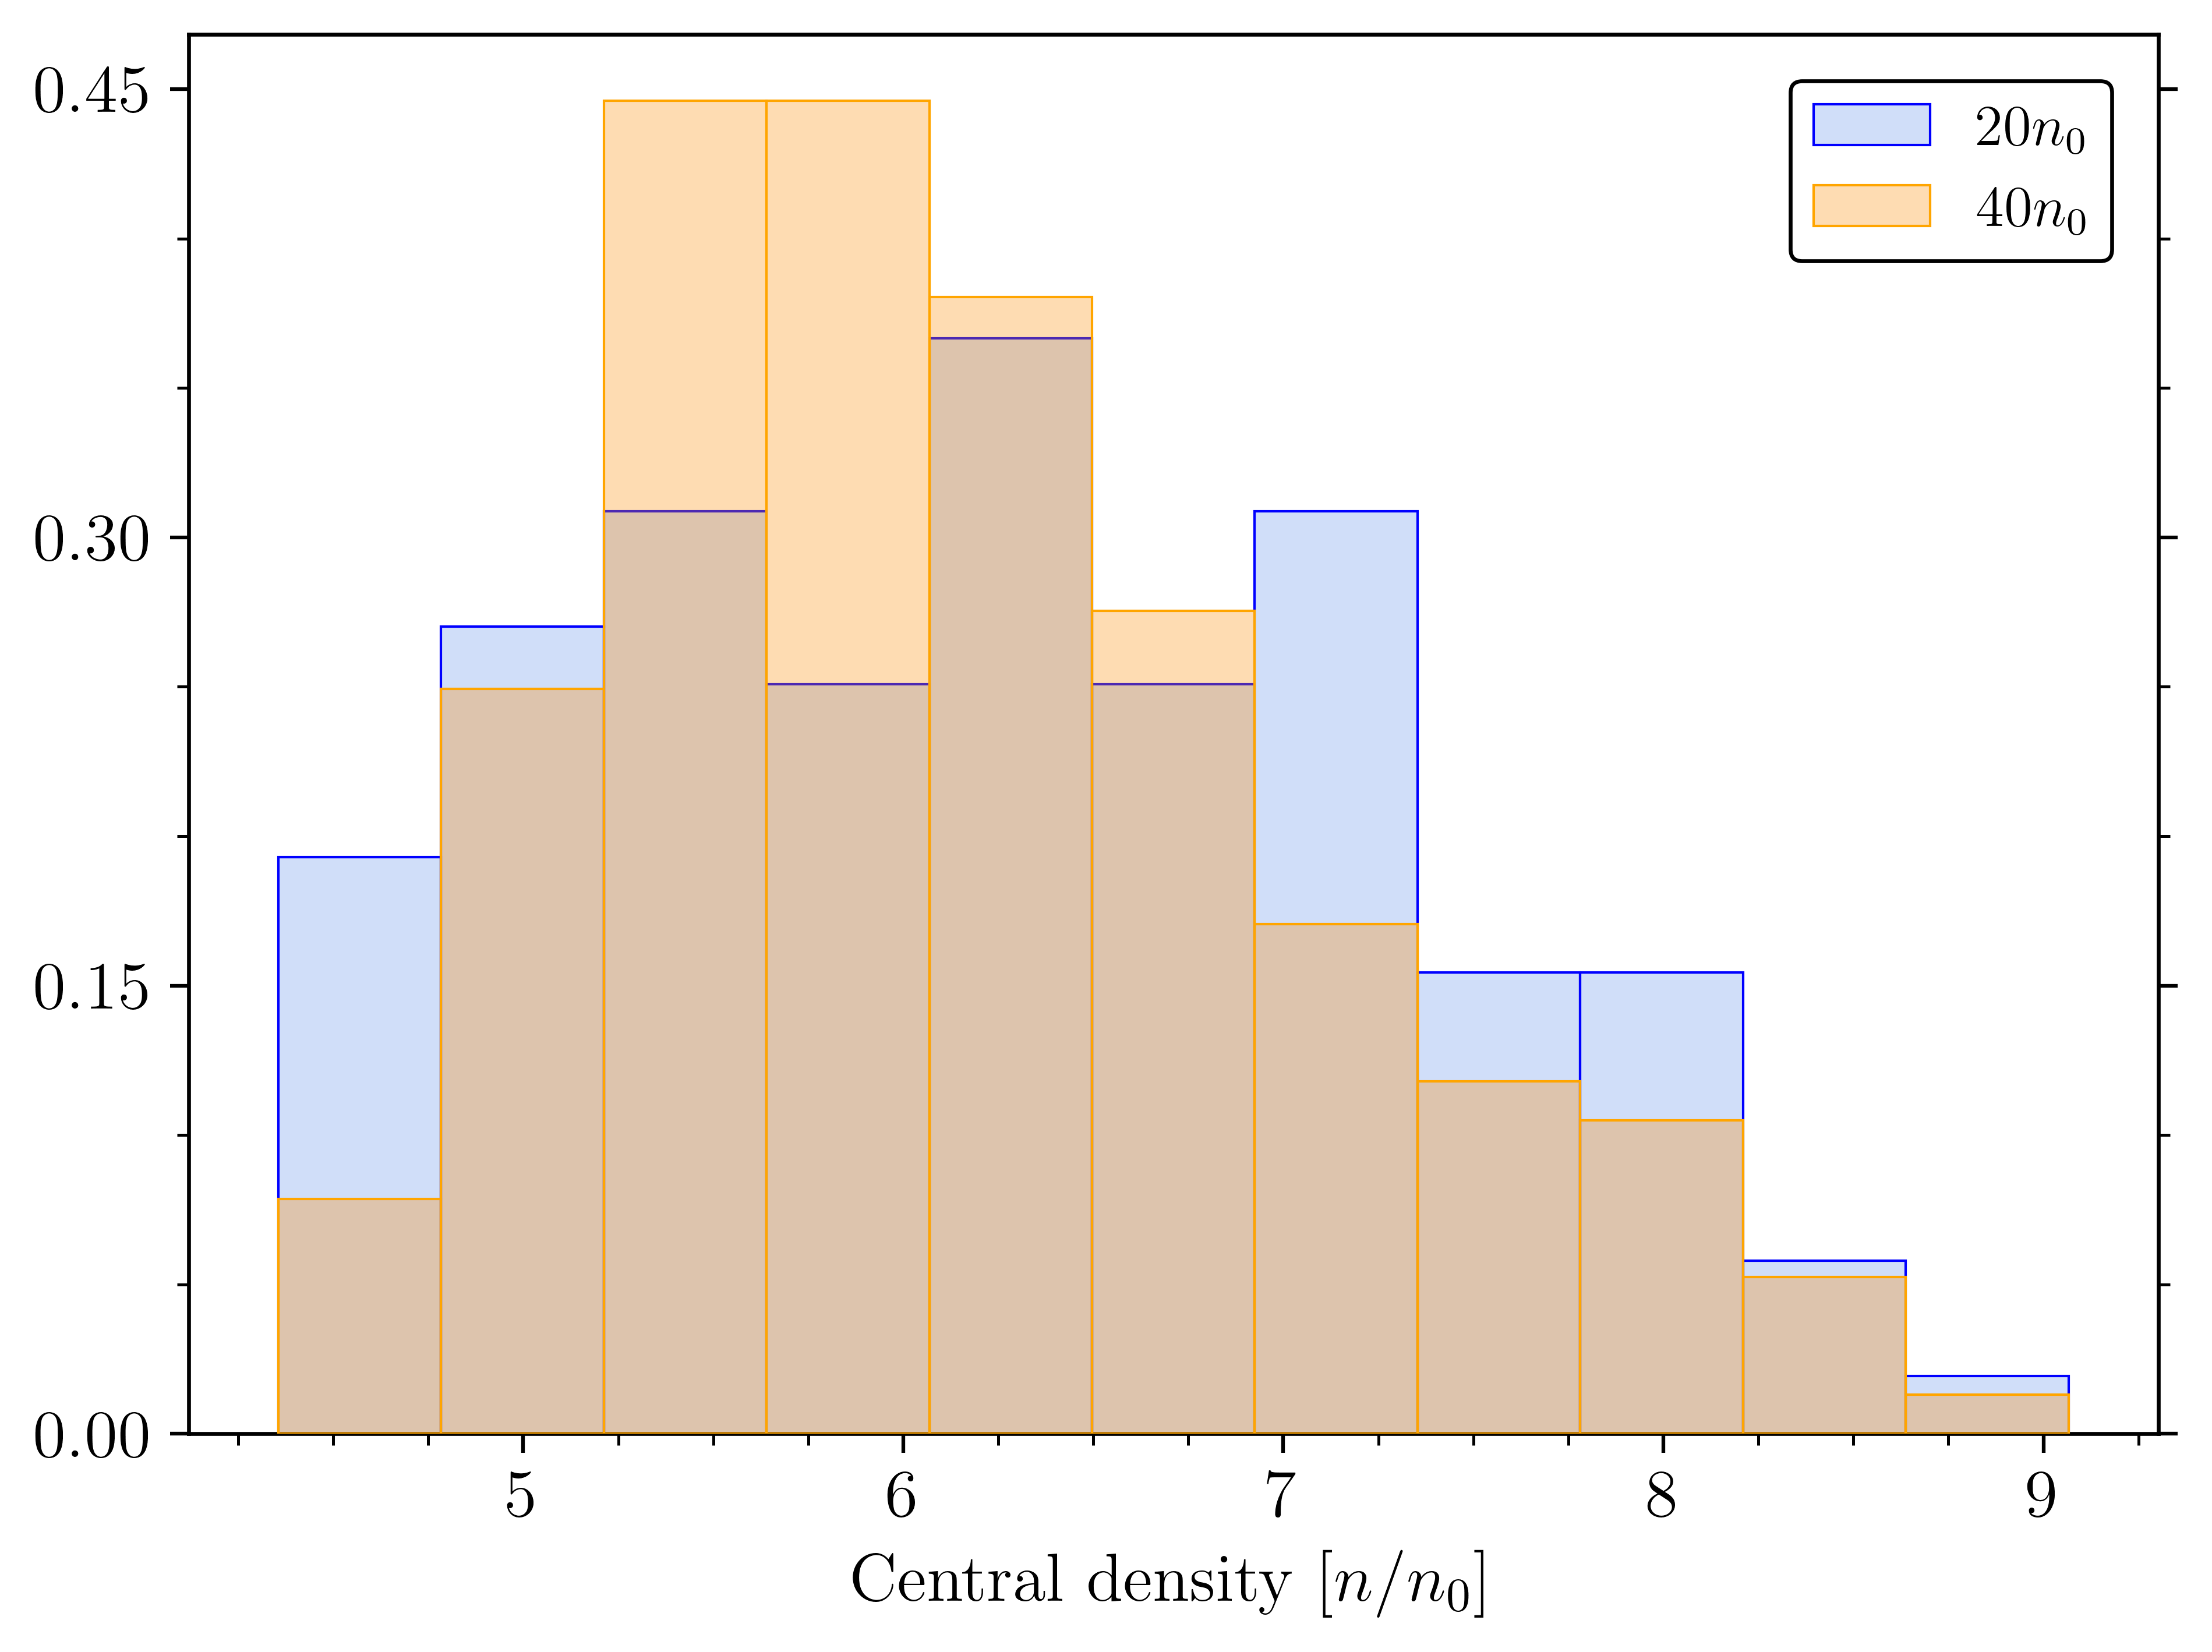

In [35]:
# combine back into one single plot
# bin the central densities and see what happens
fig = plt.figure(dpi=600)
ax = plt.axes()
ax.tick_params(axis='both', which='major', direction='out', labelsize=14, right=True)
ax.tick_params(axis='both', which='minor', direction='out', labelsize=14, right=True)
ax.yaxis.set_major_locator(MultipleLocator(0.15))
ax.yaxis.set_minor_locator(AutoMinorLocator(3))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(4))

cdens_scaled = cdens_20_reduced/n0
cdens_scaled_40 = cdens_40_reduced/n0

# 20n0 figure
n_20n0, bins_20n0, patches_20n0 = ax.hist(
    cdens_scaled, 
    bins=bins, 
    density=True, 
    edgecolor='blue',
    linewidth=0.5,
    label=r'$20n_{0}$',
    zorder=1
)

# 40n0 figure (separate for now)
n_40n0, bins_40n0, patches_40n0 = ax.hist(
    cdens_scaled_40,
    bins=bins,
    density=True,
    edgecolor='orange',
    linewidth=0.5,
    label=r'$40n_{0}$',
    zorder=10
)

for patch in patches_20n0:
    patch.set_facecolor((100/256, 149/256, 237/256, 0.3))  # cornflower blue
for patch in patches_40n0:
    patch.set_facecolor((255/256, 140/256, 0/256, 0.3))  # dark orange
ax.set_xlabel(r'Central density [$n/n_0$]', fontsize=14)
ax.legend(fontsize=12)
fig.tight_layout()
plt.subplots_adjust(hspace=0)
fig.savefig('histogram_central_densities_reduced_one_plot.png')
plt.show()

In [7]:
# load the data for the overlay plot
stationary_20 = np.load('rpm_results_stationary_20n0.npz')
stationary_40 = np.load('rpm_results_stationary_40n0.npz')

# separate it all out
radius20n0 = stationary_20['radius']
cpres20n0 = stationary_20['central_pressure']
mass20n0 = stationary_20['mass']
maxrad20n0 = stationary_20['max_radius']
maxmass20n0 = stationary_20['max_mass']

radius40n0 = stationary_40['radius']
cpres40n0 = stationary_40['central_pressure']
mass40n0 = stationary_40['mass']
maxrad40n0 = stationary_40['max_radius']
maxmass40n0 = stationary_40['max_mass']

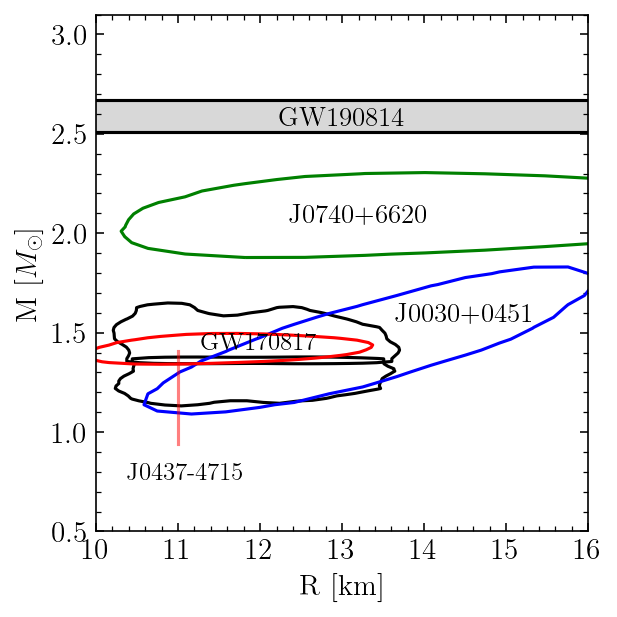

In [19]:
fig = plt.figure(figsize=(4,4), dpi=150)
ax = plt.axes()
corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=1.1, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.9, ax=ax, color=None, quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='green', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
              levels=[0.9], smooth=0.8, ax=ax, color='blue', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
              levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
              plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
              contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
              new_fig=True, force_range=False)
ax.text(13.2, 2.15, r'J0740+6620', ha='center', va='top', fontsize=13)
ax.text(14.5, 1.65, r'J0030+0451', ha='center', va='top', fontsize=13)
# GW 190814
fake_linspace = np.linspace(10.0, 16.0, 100)
gw_lower = 2.51*np.ones(len(fake_linspace))
gw_upper = 2.67*np.ones(len(fake_linspace))
ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.3, color='grey')
ax.axhline(y=2.51, color='k')
ax.axhline(y=2.67, color='k')
ax.text(13.0, 2.635, r'GW190814', ha='center', va='top', fontsize=13)
ax.set_ylim(0.5,3.1)
ax.set_xlim(10.0,16.0)
# ax.xaxis.set_major_locator(MultipleLocator(0.25))
ax.tick_params(right=True, top=True, which='both', labelsize=14)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(AutoMinorLocator(5))
ax.set_xlabel(r'R [km]', fontsize=14)
ax.set_ylabel(r'M [$M_{\odot}$]', fontsize=14)
ax.text(12.0, 1.5, r'GW170817', ha='center', va='top', fontsize=12)
ax.axvline(x=11.0, ymin=0.17, ymax=0.35, color='red', alpha=0.5)
ax.text(11.1, 0.85, r'J0437-4715', ha='center', va='top', fontsize=12)
plt.show()
plt.show()

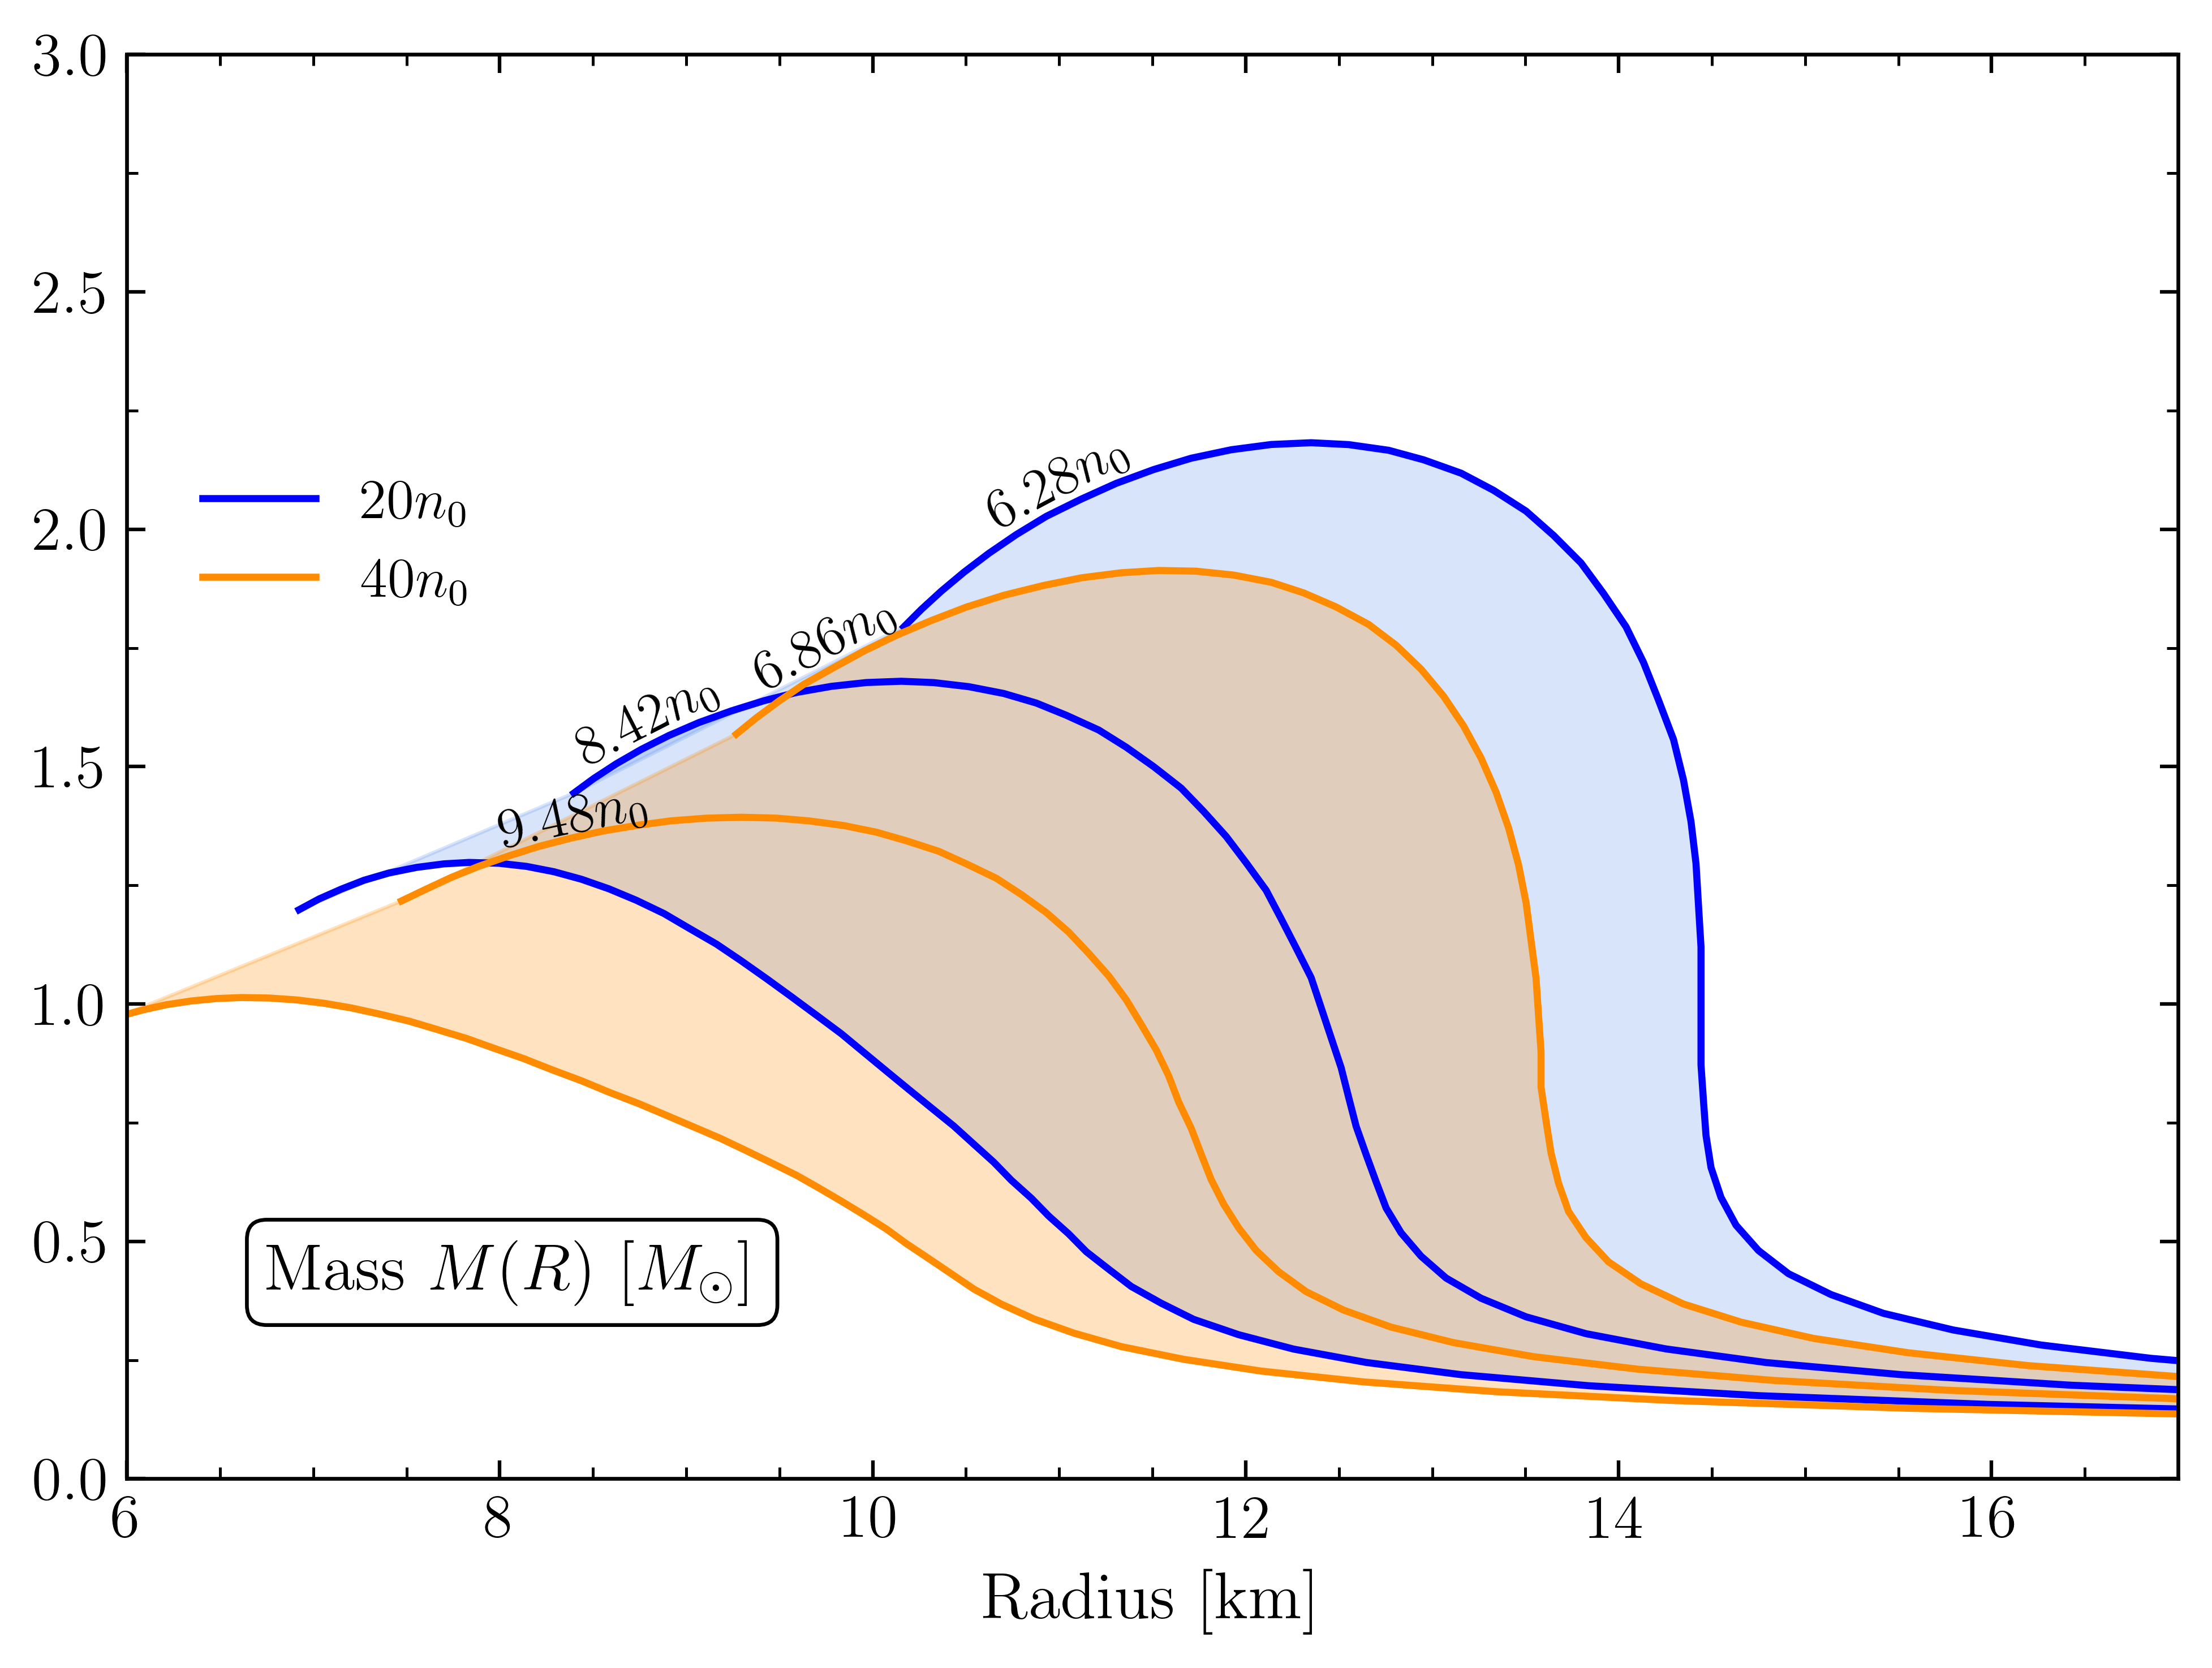

In [21]:
import matplotlib.patches as mpatches

# # define royal purple for contours
#royal_purple = '#9B30FF'

# plot the results including the samples and the overall mean, std_dev
fig, ax = plt.subplots(1,1, dpi=600)

# means
ax.plot(radius_data_mean_20, mass_data_mean_20, color='blue', label=r'$20n_{0}$')
ax.plot(radius_data_mean_40, mass_data_mean_40, color='darkorange', label=r'$40n_{0}$')

# 20n0
vertices = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,1], mass_data_mean_20[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,2]), reversed(mass_data_mean_20[:,2]))]
vertices2 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_20[:,0], mass_data_mean_20[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_20[:,1]), reversed(mass_data_mean_20[:,1]))]

# 40n0
vertices40 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,1], mass_data_mean_40[:,1])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,2]), reversed(mass_data_mean_40[:,2]))]
vertices402 = [(x, y1_val) for x, y1_val in zip(radius_data_mean_40[:,0], mass_data_mean_40[:,0])] + \
           [(x, y2_val) for x, y2_val in zip(reversed(radius_data_mean_40[:,1]), reversed(mass_data_mean_40[:,1]))]

polygon = Polygon(vertices, closed=True, color="cornflowerblue", alpha=0.25)
polygon2 = Polygon(vertices2, closed=True, color="cornflowerblue", alpha=0.25)
plt.gca().add_patch(polygon)
plt.gca().add_patch(polygon2)

polygon40 = Polygon(vertices40, closed=True, color="darkorange", alpha=0.25)
polygon402 = Polygon(vertices402, closed=True, color="darkorange", alpha=0.25)
plt.gca().add_patch(polygon40)
plt.gca().add_patch(polygon402)

handles, labels = plt.gca().get_legend_handles_labels()

# remove duplicates by converting to a dictionary
unique = dict(zip(labels, handles))
legend = ax.legend(unique.values(), unique.keys(), fontsize=12, frameon=False, bbox_to_anchor=[0.2, 0.75])

# NICER and LIGO contours
# corner.hist2d(miller[:,0], miller[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='darkgreen', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(miller_0030_2[:,0], miller_0030_2[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.8, ax=ax, color='royalblue', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x11, y11, bins=30, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=1.1, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(x22, y22, bins=25, range=None, axes_scale=['linear', 'linear'], weights=None, \
#               levels=[0.9], smooth=0.9, ax=ax, color='maroon', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
# corner.hist2d(j0437[:,2], j0437[:,1], bins=25, range=None, axes_scale=['linear', 'linear'], weights=j0437[:,0], \
#               levels=[0.9], smooth=0.8, ax=ax, color='red', quiet=False, plot_datapoints=False, \
#               plot_density=False, plot_contours=True, no_fill_contours=True, fill_contours=False, \
#               contour_kwargs=None, contourf_kwargs=None, data_kwargs=None, pcolor_kwargs=None, \
#               new_fig=False)
    
# labels for LIGO and NICER data
# ax.text(13.2, 2.15, r'$\textbf{J0740+6620}$', ha='center', va='top', fontsize=13)
# ax.text(14.5, 1.65, r'$\textbf{J0030+0451}$', ha='center', va='top', fontsize=13)

# # GW 190814
# fake_linspace = np.linspace(6.0, 17.0, 100)
# gw_lower = 2.51*np.ones(len(fake_linspace))
# gw_upper = 2.67*np.ones(len(fake_linspace))
# ax.fill_between(fake_linspace, gw_lower, gw_upper, alpha=0.25, color='grey', hatch='/')
# ax.axhline(y=2.51, color='lightgrey')
# ax.axhline(y=2.67, color='lightgrey')
# ax.text(11.5, 2.635, r'$\textbf{GW190814}$', ha='center', va='top', fontsize=13)
# ax.text(12.0, 1.525, r'$\textbf{GW170817}$', ha='center', va='top', fontsize=13, zorder=10)
# ax.axvline(x=11.0, ymin=0.30, ymax=0.475, color='red', alpha=0.5)
# ax.text(11.1, 0.85, r'$\textbf{J0437-4715}$', ha='center', va='top', fontsize=13)

# adding labels for central densities of the top 2 curves
ax.text(8.4, 1.39, r'{:.2f}$n_0$'.format(cdens_mean_40[1]/n0), rotation=12, va='center', \
        ha='center', fontsize=12)
ax.text(9.75, 1.76, r'{:.2f}$n_0$'.format(cdens_mean_40[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.text(8.8, 1.6, r'{:.2f}$n_0$'.format(cdens_mean_20[1]/n0), rotation=27, va='center', \
        ha='center', fontsize=12)
ax.text(11.0, 2.1, r'{:.2f}$n_0$'.format(cdens_mean_20[2]/n0), rotation=28, va='center', \
        ha='center', fontsize=12)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))
ax.tick_params(axis='both', which='major', labelsize=13, right=True, top=True)
ax.tick_params(axis='both', which='minor', labelsize=13, right=True, top=True)
ax.set_xlim(6.0, 17.0)
ax.set_ylim(0.0,3.0)
ax.set_xlabel(r'Radius [km]', fontsize=14)
ax.text(6.75, 0.40, r'Mass $M(R)$ $[M_\odot]$', fontsize=14, bbox=dict(facecolor='w', boxstyle='round'))
fig.savefig('basic_overlay_mr_curves.png')
plt.show()

# extract the contour, see if we can use it for the selection of curves!
# contour_collections = ax.collections
# contours = contour_collections[:2]

# vertices = []
# for contour in contours:
#     for path in contour.get_paths():
#         vertices.append(path.vertices)
        
# vertices_first = np.asarray(vertices)[0]

In [22]:
# write central densities
print(cdens_mean_20/n0)
print(cdens_mean_40/n0)

[12.87840579  8.41507544  6.27853489]
[17.37175092  9.47951654  6.85772183]
